In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import seaborn as sns
# from statsmodels import api
from scipy import stats
from scipy.optimize import minimize 
import json
# import pprint


In [50]:
# This function cleans the data and creates c_0, c_f, and log_c_f

def cleanData(df):
    # Remove unnecessary columns
    df = df.drop('Link', axis=1)
    df = df[df['Cited by'] > 0]
    df['c_0'] = 0


    # Calc c_0      
    c_0 = {
        2010: df.loc[df['Year'] == 2010, 'Cited by'].mean(),
        2011: df.loc[df['Year'] == 2011, 'Cited by'].mean(),
        2012: df.loc[df['Year'] == 2012, 'Cited by'].mean(),
        2013: df.loc[df['Year'] == 2013, 'Cited by'].mean(),
        2014: df.loc[df['Year'] == 2014, 'Cited by'].mean(),
        2015: df.loc[df['Year'] == 2015, 'Cited by'].mean()
    }
    for index, row in df.iterrows():
        df['c_0'][index] = c_0[row['Year']]
  
    # Calc c_f
    df['c_f'] = df['Cited by'] / df['c_0']

    df['log_c_f'] = np.log(df['c_f'])

    return df




In [51]:
# This function defines the log-likelihood function that is used in the optimisation

def get_opti_fun(df):
   # MLE function
   def MLE_Norm(parameters):
      # extract parameters
      mu, sigma = parameters
      # Calculate the log-likelihood for normal distribution
      ##LL = np.sum(stats.norm.logpdf(df['log_c_f'], loc=mu, scale=sigma))
      LL = np.sum(stats.norm.logpdf(x=df["log_c_f"], loc = mu, scale = sigma))
      
      # Calculate the negative log-likelihood
      neg_LL = -1*LL
      return neg_LL
   return MLE_Norm

In [52]:
# Load data sets

sen_tec = pd.read_csv('sensor_technology.csv')
col_sys = pd.read_csv('Swarming_MultiAgent.csv')
tec_mob = pd.read_csv('Robotics.csv')
cont_alg = pd.read_csv('ControlSystems_Algorithms.csv')
loc_map = pd.read_csv('Localisation_Mapping.csv')
sen_fus = pd.read_csv('sensor_fusion.csv')
ai_ml = pd.read_csv('AI_ML.csv')
edg_com = pd.read_csv('EdgeComputing.csv')
com_net = pd.read_csv('Communications_Networking.csv')
ene_mgm = pd.read_excel('EnergyManagement.xlsx')
sim_mod = pd.read_csv('Simulation_Modeling.csv')
hum_man  = pd.read_csv('HumanMachineInteraction.csv')
cyb_sec = pd.read_csv('CyberSecurity.csv')
eth_reg =pd.read_excel('EthicsRegulations.xlsx')


dataSets = [sen_tec, col_sys, tec_mob, cont_alg, loc_map, sen_fus, ai_ml, edg_com, com_net, ene_mgm, sim_mod, hum_man, cyb_sec, eth_reg]
keyNames = ["sen_tec", "col_sys", "tec_mob", "cont_alg", "loc_map", "sen_fus", "ai_ml", "edg_com", "com_net", "ene_mgm", "sim_mod", "hum_man", "cyb_sec", "eth_reg"]

In [53]:
# Function that performs the maximum likelihood-estimation. Outputs a dict of parameters for each technology

def MLE_estimation(dataSets, keyNames):

    parameterDict = {}
    initParams = [1,1]
    
    for index, df in enumerate(dataSets):
        df = cleanData(df)

        mle = minimize(get_opti_fun(df), initParams, method='Nelder-Mead')
        mu = mle.x[0]
        sigma = mle.x[1]
        parameterDict.update({keyNames[index]: {'mu': mu}})
        parameterDict[keyNames[index]].update({'sigma': sigma})

    return parameterDict

        

In [54]:
# Perform the estimation

parameters = MLE_estimation(dataSets, keyNames)

/var/folders/9r/w8p_5y0s0913xqcffg4y86sr0000gn/T/ipykernel_13955/1253599995.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_0'][index] = c_0[row['Year']]
/var/folders/9r/w8p_5y0s0913xqcffg4y86sr0000gn/T/ipykernel_13955/1253599995.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c_0'][index] = c_0[row['Year']]
/var/folders/9r/w8p_5y0s0913xqcffg4y86sr0000gn/T/ipykernel_13955/1253599995.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [55]:
with open("distribution_params.json", "w") as write_file:
    json.dump(parameters, write_file, indent=4)

In [56]:
parameters

{'sen_tec': {'mu': -0.9657359048121048, 'sigma': 1.3653131476411307},
 'col_sys': {'mu': -0.5216991391810393, 'sigma': 0.8769489580459121},
 'tec_mob': {'mu': -0.28433042470183617, 'sigma': 0.6002492792460522},
 'cont_alg': {'mu': -0.3119378754147418, 'sigma': 0.6769543590139491},
 'loc_map': {'mu': -0.3003677245964875, 'sigma': 0.6310363643099357},
 'sen_fus': {'mu': -1.081137272906017, 'sigma': 1.3830866052163735},
 'ai_ml': {'mu': -0.386351113101974, 'sigma': 0.644401741347951},
 'edg_com': {'mu': -0.4382650698614001, 'sigma': 0.7444251571378885},
 'com_net': {'mu': -0.29729339876492644, 'sigma': 0.6389827943670707},
 'ene_mgm': {'mu': -0.9503314082979302, 'sigma': 1.3935521859730473},
 'sim_mod': {'mu': -0.225569901458396, 'sigma': 0.528705539762359},
 'hum_man': {'mu': -0.3598329582695039, 'sigma': 0.6943185304775856},
 'cyb_sec': {'mu': -1.0912355018062412, 'sigma': 1.373858192556956},
 'eth_reg': {'mu': -0.849534319137371, 'sigma': 1.2960729588759439}}

In [60]:
def plot_dist(dataSets, parameters=parameters, keyNames=keyNames):
    
    key_names = ["ai_ml", "com_net", "con_alg", "edge_com", "loc_map", "rob", "sen_fus", "sen_tec", "sim_mod", "swarm_mult", "hum_mac", "cyb_sec"]

    for index, df in enumerate(dataSets):
        mu = parameters[keyNames[index]]["mu"]
        sigma = parameters[keyNames[index]]["sigma"]
        dist = stats.lognorm([sigma], loc=mu)
        x = np.linspace(0,100,1000)
        plt.xlabel("c_f")
        plt.ylabel("P(c|c_0)")
        plt.legend(key_names, )
        plt.xscale("log")
        plt.yscale("log")
        plt.plot(x,dist.pdf(x))

In [61]:
def plot_dist2(dataSets, parameters=parameters, keyNames=keyNames):
    
    key_names = ["ai_ml", "com_net", "con_alg", "edge_com", "loc_map", "rob", "sen_fus", "sen_tec", "sim_mod", "swarm_mult", "hum_mac", "cyb_sec"]

    for index, df in enumerate(dataSets):
        mu = parameters[keyNames[index]]["mu"]
        sigma = parameters[keyNames[index]]["sigma"]
        dist = stats.norm(loc=mu, scale = sigma)
        
        x = np.linspace(-2,5,2000)
        
        p = dist.pdf(np.log(x))
        
        
        plt.plot(x,p)
        plt.legend(key_names, )
        
        
        # plt.xlabel("c_f")
        # plt.ylabel("P(c|c_0)")
        # plt.legend(key_names, )
        # #plt.xscale("log")
        # #plt.yscale("log")
        # plt.plot(x,dist.pdf(x))

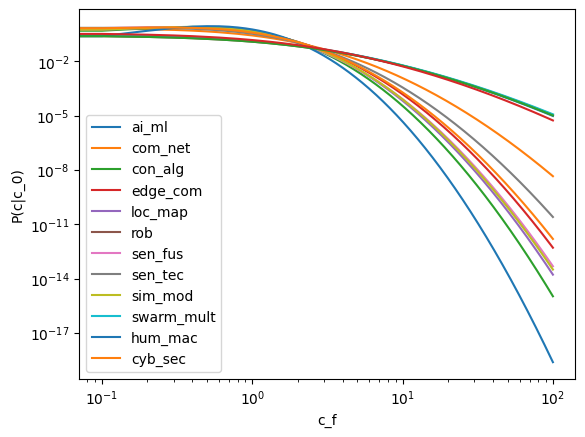

In [62]:
plot_dist(dataSets)

/var/folders/9r/w8p_5y0s0913xqcffg4y86sr0000gn/T/ipykernel_13955/1719491544.py:12: RuntimeWarning: invalid value encountered in log
  p = dist.pdf(np.log(x))


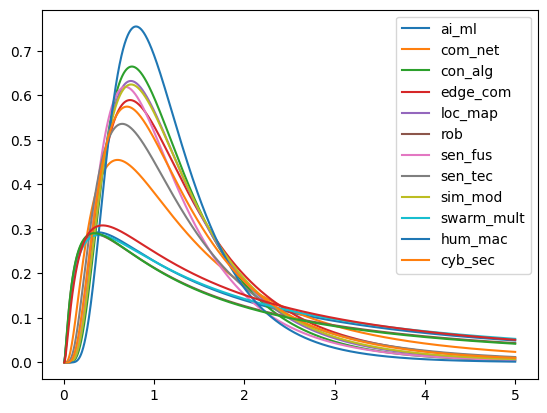

In [63]:
plot_dist2(dataSets)

<Axes: >

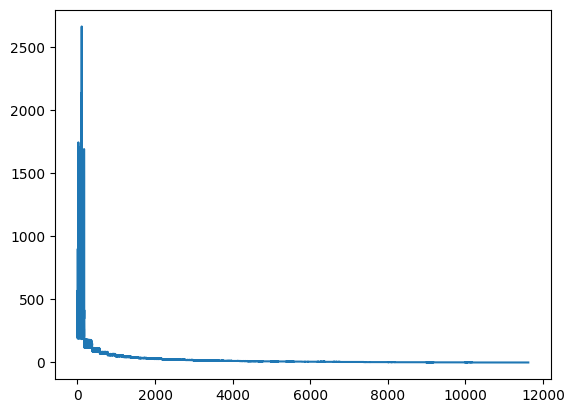

In [64]:
sen_fus["Cited by"].plot()